In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import joblib
from helpers import helpers_functions

In [2]:
df = pd.read_csv("datasets/tsla_data.csv")

In [3]:
df["date"] = pd.to_datetime(df["date"])

In [4]:
df.dtypes

date                datetime64[ns]
open                       float64
high                       float64
low                        float64
close                      float64
adjClose                   float64
volume                       int64
unadjustedVolume             int64
change                     float64
changePercent              float64
vwap                       float64
label                       object
changeOverTime             float64
dtype: object

In [5]:
df = df[["date","close","open"]]

In [6]:
df.sort_values(by="date", inplace=True)

In [7]:
df.set_index("date", inplace=True)

In [8]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('\n')

In [9]:
df_diff = df.diff().dropna() 

In [10]:
print(df_diff.dtypes)


close    float64
open     float64
dtype: object


In [11]:
model = VAR(df_diff)
model_fitted = model.fit(maxlags=4, ic='aic')  

print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 22, Aug, 2024
Time:                     15:25:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.14838
Nobs:                     1252.00    HQIC:                   7.10233
Log likelihood:          -7963.72    FPE:                    1181.56
AIC:                      7.07459    Det(Omega_mle):         1164.76
--------------------------------------------------------------------
Results for equation close
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.157369         0.227881            0.691           0.490
L1.close        -0.038930         0.032738           -1.189           0.234
L1.open          0.054673         0.051957            1.052           0.293
L2.c

c:\Users\MEHMET\Desktop\stock_forecast\stenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
lag_order = model_fitted.k_ar
forecast_input = df_diff.values[-lag_order:]

In [13]:
forecast = model_fitted.forecast(y=forecast_input, steps=10)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1] + pd.DateOffset(1), periods=10, freq='D'), columns=df_diff.columns)

print(forecast_df)

               close      open
2024-08-16 -0.757732  8.621401
2024-08-17  0.967137  0.039518
2024-08-18 -0.635213 -0.246120
2024-08-19  1.242579  0.812993
2024-08-20 -0.346226 -0.371697
2024-08-21  0.145437  0.533255
2024-08-22  0.220454 -0.085721
2024-08-23  0.196982  0.370921
2024-08-24  0.128169 -0.037691
2024-08-25  0.129243  0.274052


In [15]:
forecast_df_final = helpers_functions.invert_transformation(df, forecast_df)
print(forecast_df_final)

                 close        open
2024-08-16  213.382268  213.641401
2024-08-17  214.349406  213.680919
2024-08-18  213.714193  213.434799
2024-08-19  214.956771  214.247792
2024-08-20  214.610546  213.876095
2024-08-21  214.755983  214.409350
2024-08-22  214.976437  214.323629
2024-08-23  215.173419  214.694550
2024-08-24  215.301588  214.656859
2024-08-25  215.430831  214.930911


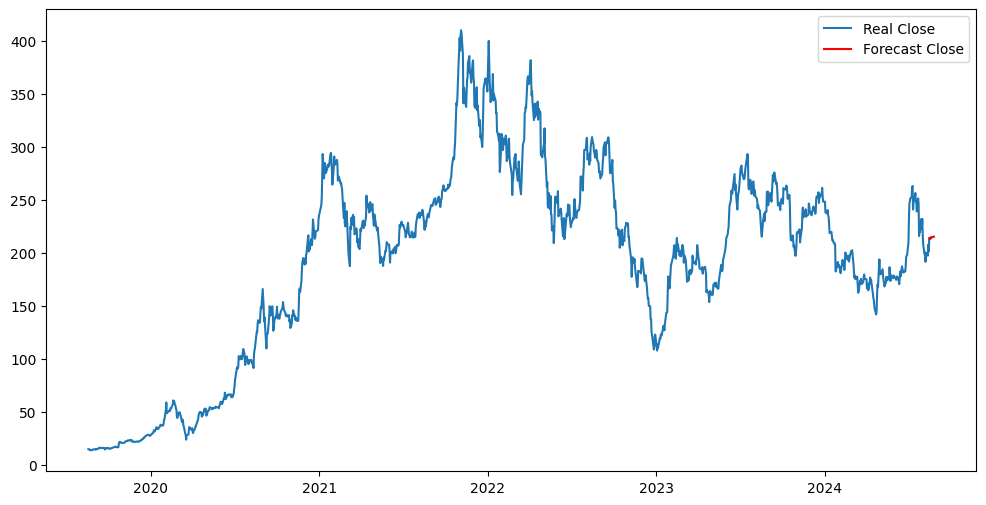

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], label='Real Close')
plt.plot(forecast_df_final.index, forecast_df_final['close'], label='Forecast Close', color='red')
plt.legend()
plt.show()

In [17]:
joblib.dump(model_fitted, "var_model.pkl")

['var_model.pkl']